先不做gridsearchCV 而是先确定哪个模型初步表现最好. 哪个target最有解释力和预测里. 是否存在明显欠拟合和过拟合. 

结论: baseline 结果整体非常优秀且健康：非线性模型（尤其是 XGBoost 与 LightGBM）在 salary_cap_ratio 上 R² 稳定在 0.79 左右，说明特征工程与目标选择正确有效；Core 特征集兼顾解释性，Full 特征集提供了更强预测力；目标变量的表现也与 EDA 结论一致。此外，模型之间的差异符合预期，XGB/LGBM 表现最好，RF 稳定但略低，MLP 波动较大。没有出现过拟合或异常值，说明整个数据预处理和特征筛选流程非常成功。✅ 接下来可以进入模型调优阶段（交叉验证 + GridSearchCV），进一步提升稳定性和精度。

In [3]:
# %% [markdown]
# # EDA_4 — Baseline Modeling (Full Suite)
# Models: Ridge (linear), RandomForest, XGBoost, LightGBM, MLP
# Feature sets: core (explainable) & full (accurate)
# Targets: salary_cap_ratio (default) + four variants
# Outputs -> reports/baseline/: metrics CSV, residual plots, importances

# %%
from pathlib import Path
import json, warnings, numpy as np, pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance

# Optional libs (graceful fallback)
try:
    import xgboost as xgb
    XGB_OK = True
except Exception:
    XGB_OK = False

try:
    from lightgbm import LGBMRegressor
    LGBM_OK = True
except Exception:
    LGBM_OK = False

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

warnings.filterwarnings("ignore")

# --- Paths ---
DATA_FEAT_PATH = Path("../data/processed/training_oncourt_features.parquet")
EDA3_DIR       = Path("reports/features")
OUT_DIR        = Path("reports/baseline")
OUT_DIR.mkdir(parents=True, exist_ok=True)

CORE_FILE = EDA3_DIR / "selected_features_core.json"   # 可能是json或纯文本行
FULL_FILE = EDA3_DIR / "selected_features_full.json"   # 通常是{"features":[...]}

In [4]:
# %%
df = pd.read_parquet(DATA_FEAT_PATH)
print("Data shape:", df.shape)

def load_feature_list(p: Path):
    """
    兼容两种情况：
      1) JSON: {"features": [...]}
      2) 纯文本：每行一个特征
    """
    txt = p.read_text(encoding="utf-8").strip()
    try:
        obj = json.loads(txt)
        if isinstance(obj, dict) and "features" in obj:
            return list(obj["features"])
        elif isinstance(obj, list):
            return list(obj)
    except Exception:
        pass
    # 纯文本
    return [line.strip() for line in txt.splitlines() if line.strip()]

core_feats = load_feature_list(CORE_FILE)
full_feats = load_feature_list(FULL_FILE)

print(f"Core features ({len(core_feats)}):", core_feats[:10], "...")
print(f"Full  features ({len(full_feats)}):", full_feats[:10], "...")

Data shape: (2082, 90)
Core features (10): ['FP', 'Age', 'Min', 'FTA', 'TOV', 'PTS_per_gp', 'log1p_PF', 'log1p_3PM', 'PTS_per_min', 'OREB_per_min'] ...
Full  features (40): ['FP', 'PTS', 'Age', 'Min', 'FTA', 'TOV', 'PTS_per_gp', 'log1p_PF', 'log1p_3PM', 'PTS_per_min'] ...


In [5]:
# %%
TARGETS = [
    "salary_cap_ratio",       # ✅ 推荐主目标
    "salary_cap_equiv",
    "log_salary_cap_ratio",
    "salary_usd",
    "log_salary",
]
TARGETS_TO_RUN = TARGETS  # 如需全跑：= TARGETS


for t in TARGETS_TO_RUN:
    assert t in df.columns, f"Missing target: {t}"

In [6]:
# %%
RANDOM_STATE = 42 #固定随机种子
TEST_SIZE    = 0.2# 测试20 训练80

# 构造x和y 
def make_xy(df: pd.DataFrame, features: list[str], target: str):
    X = df[features].copy().fillna(0)
    y = df[target].copy().fillna(0)
    return X, y

# 划分训练集和测试集
def split_xy(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE):
    return train_test_split(X, y, test_size=test_size, random_state=random_state)

# 评估模型 r2 以及RMSE
def evaluate(y_true, y_pred):
    return r2_score(y_true, y_pred), mean_squared_error(y_true, y_pred, squared=False)

# 绘制残差图
def plot_residuals(y_true, y_pred, out_png: Path | None):
    resid = y_true - y_pred
    plt.figure(figsize=(5,4))
    plt.scatter(y_pred, resid, s=8, alpha=0.6)
    plt.axhline(0, color="gray", linestyle="--") # 画出y = 0 的水平线
    plt.xlabel("Predicted"); plt.ylabel("Residuals"); plt.title("Residuals")
    plt.tight_layout()
    if out_png: plt.savefig(out_png, dpi=160)
    plt.show()

# 保存特征重要性 画图
def save_importance(series: pd.Series, out_csv: Path, topk_plot: int = 25):
    series.sort_values(ascending=False).to_csv(out_csv, header=["importance"])
    # 条形图
    top = series.sort_values().tail(topk_plot)
    plt.figure(figsize=(6, max(3, 0.3*len(top))))
    top.plot(kind="barh")
    plt.title(out_csv.stem)
    plt.tight_layout()
    plt.savefig(out_csv.with_suffix(".png"), dpi=160)
    plt.show()

In [11]:
# %% 都输入训练集 和验证集Xva yva
def fit_ridge(Xtr, ytr, Xva, yva, alpha=1.0):
    # 用pipeline 把标准化和Ridge 串起来 alpha 是L2正则强度 越大越收缩系数
    pipe = Pipeline([
        ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ("ridge",  Ridge(alpha=alpha, random_state=RANDOM_STATE))
    ])
    pipe.fit(Xtr, ytr)
    pred = pipe.predict(Xva)
    # 线性模型的“重要性”用 |coef|
    # 取回归系数的绝对值作为重要性
    coefs = np.abs(pipe.named_steps["ridge"].coef_)
    imp = pd.Series(coefs, index=Xtr.columns)
    return "Ridge", pipe, pred, imp

# 你怎么就知道一开始是800？
def fit_rf(Xtr, ytr, Xva, yva):
    rf = RandomForestRegressor(
        n_estimators=800, random_state=RANDOM_STATE, n_jobs=-1
    )
    rf.fit(Xtr, ytr)
    pred = rf.predict(Xva)
    imp = pd.Series(rf.feature_importances_, index=Xtr.columns)
    return "RF", rf, pred, imp


def fit_xgb(Xtr, ytr, Xva, yva):
    if not XGB_OK:
        return None, None, None, None
    dtr = xgb.DMatrix(Xtr, label=ytr)
    dva = xgb.DMatrix(Xva, label=yva)
    params = {
        "objective": "reg:squarederror",
        "max_depth": 6, # 你怎么知道树的深度是6
        "eta": 0.1,
        "subsample": 0.8,
        "colsample_bytree": 0.8,
        "seed": RANDOM_STATE,
    }
    booster = xgb.train(
        params, dtr, num_boost_round=500,
        evals=[(dva,"val")], early_stopping_rounds=30, verbose_eval=False
    )
    pred = booster.predict(dva)
    # importance (gain)
    score_map = booster.get_score(importance_type="gain")
    imp = pd.Series({k: score_map.get(k, 0.0) for k in Xtr.columns})
    return "XGB", booster, pred, imp

# 你怎么知道n_estimators = 600？
def fit_lgbm(Xtr, ytr, Xva, yva):
    if not LGBM_OK:
        return None, None, None, None
    lgbm = LGBMRegressor(
        n_estimators=600,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=RANDOM_STATE
    )
    # 移除 verbose
    lgbm.fit(Xtr, ytr, eval_set=[(Xva, yva)], eval_metric="l2")
    pred = lgbm.predict(Xva)
    imp = pd.Series(lgbm.feature_importances_, index=Xtr.columns)
    return "LGBM", lgbm, pred, imp

def fit_mlp(Xtr, ytr, Xva, yva):
    # 标准化对 MLP 很重要
    pipe = Pipeline([
        ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ("mlp", MLPRegressor(hidden_layer_sizes=(128,64), activation="relu",
                             max_iter=1000, random_state=RANDOM_STATE))
    ])
    pipe.fit(Xtr, ytr)
    pred = pipe.predict(Xva)
    # MLP 无原生 importance，用 permutation importance 近似（在验证集上）
    pi = permutation_importance(pipe, Xva, yva, n_repeats=10, random_state=RANDOM_STATE, n_jobs=-1)
    imp = pd.Series(pi.importances_mean, index=Xtr.columns)
    return "MLP", pipe, pred, imp


[Ridge] core target=salary_cap_ratio  R^2=0.6918 RMSE=0.051868


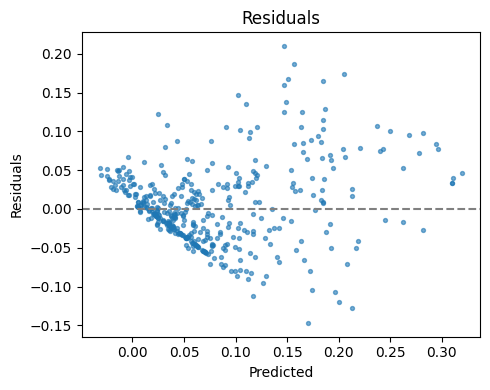

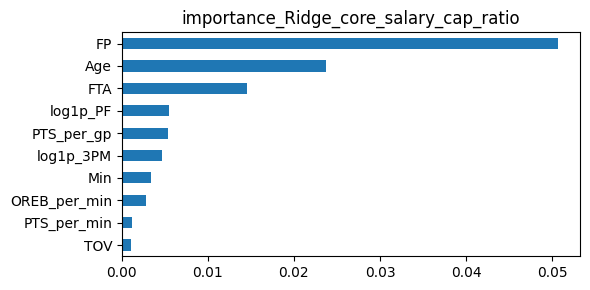

[RF] core target=salary_cap_ratio  R^2=0.7864 RMSE=0.043181


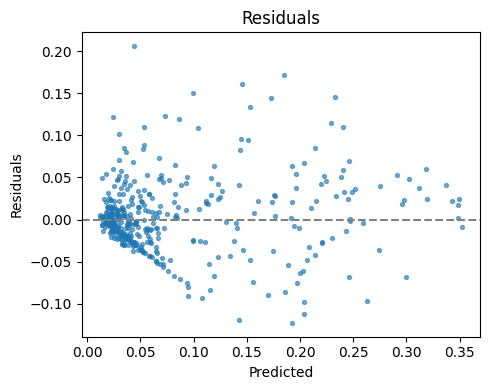

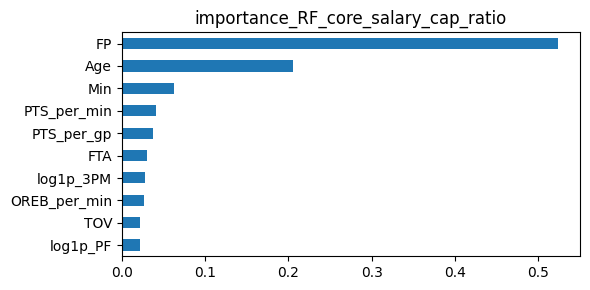

[XGB] core target=salary_cap_ratio  R^2=0.7867 RMSE=0.043146


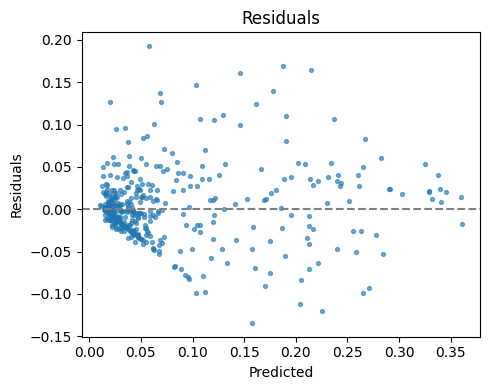

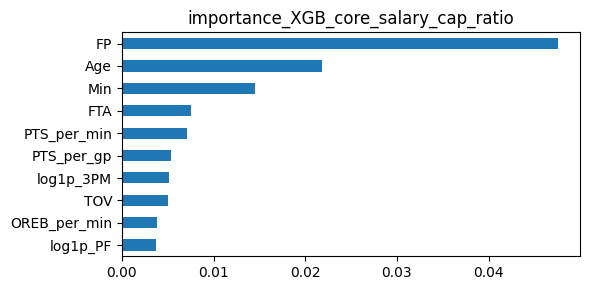

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001320 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1494
[LightGBM] [Info] Number of data points in the train set: 1665, number of used features: 10
[LightGBM] [Info] Start training from score 0.077080
[LGBM] core target=salary_cap_ratio  R^2=0.7772 RMSE=0.044106


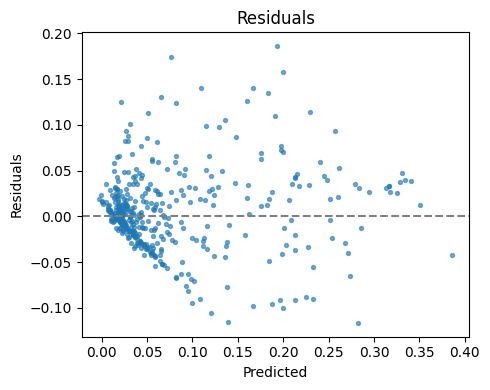

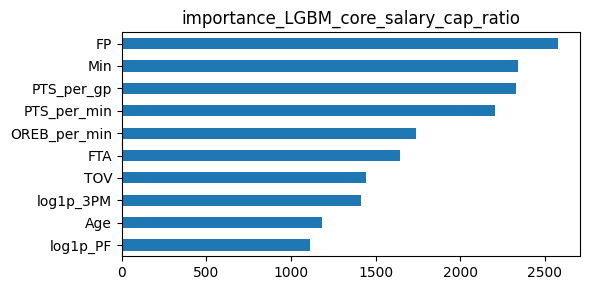

[MLP] core target=salary_cap_ratio  R^2=0.6961 RMSE=0.051508


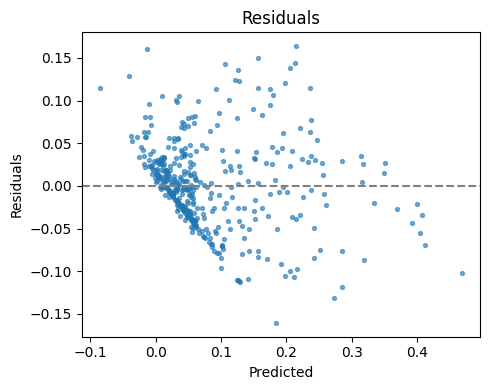

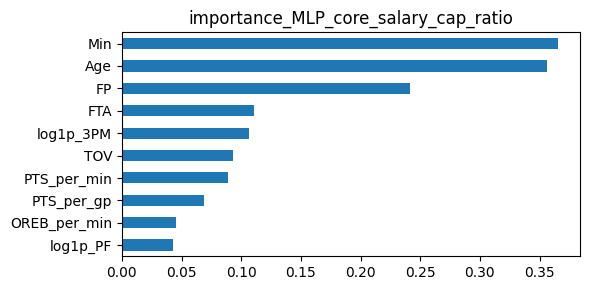

[Ridge] full target=salary_cap_ratio  R^2=0.7183 RMSE=0.049585


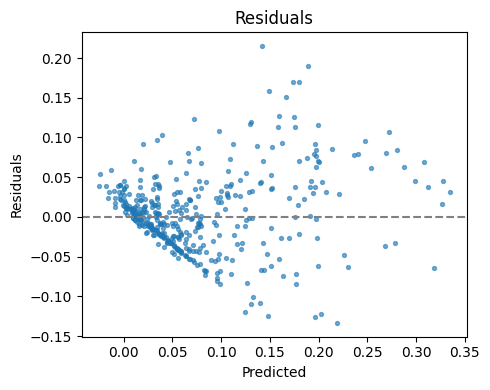

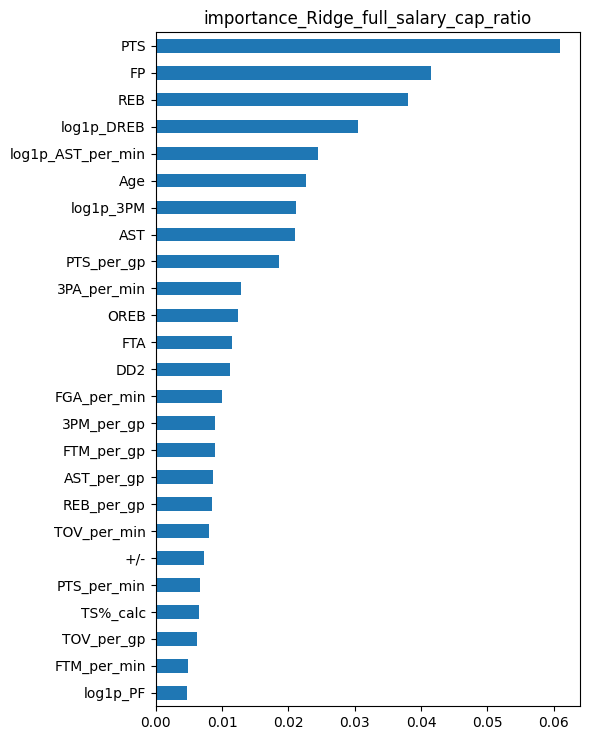

[RF] full target=salary_cap_ratio  R^2=0.7981 RMSE=0.041977


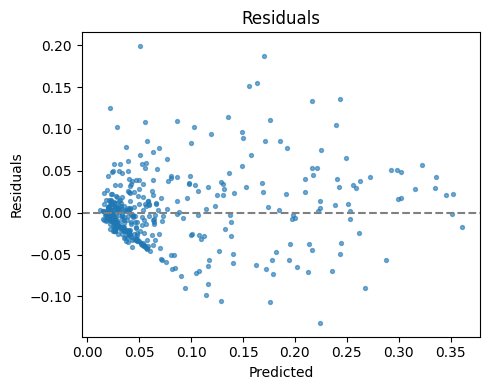

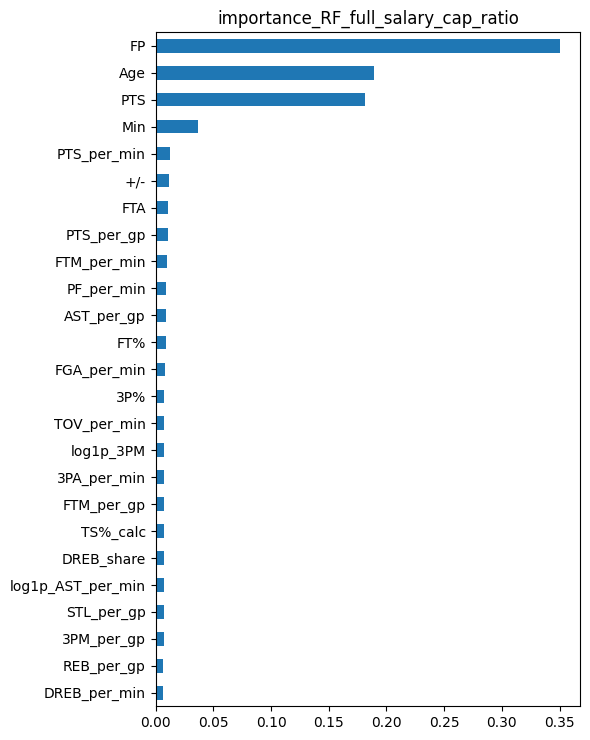

[XGB] full target=salary_cap_ratio  R^2=0.7838 RMSE=0.043443


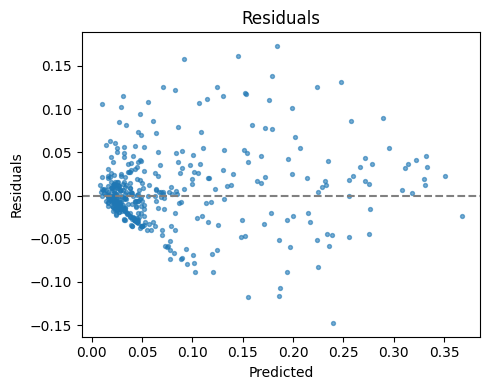

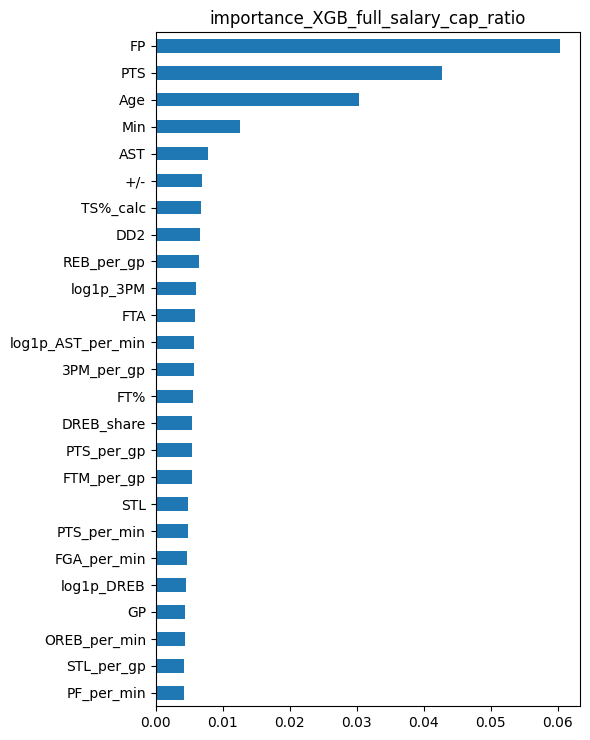

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000904 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7216
[LightGBM] [Info] Number of data points in the train set: 1665, number of used features: 40
[LightGBM] [Info] Start training from score 0.077080
[LGBM] full target=salary_cap_ratio  R^2=0.7977 RMSE=0.042027


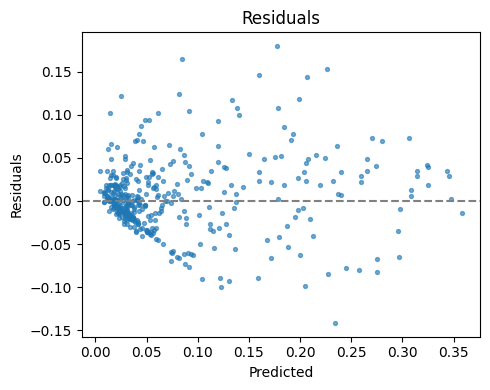

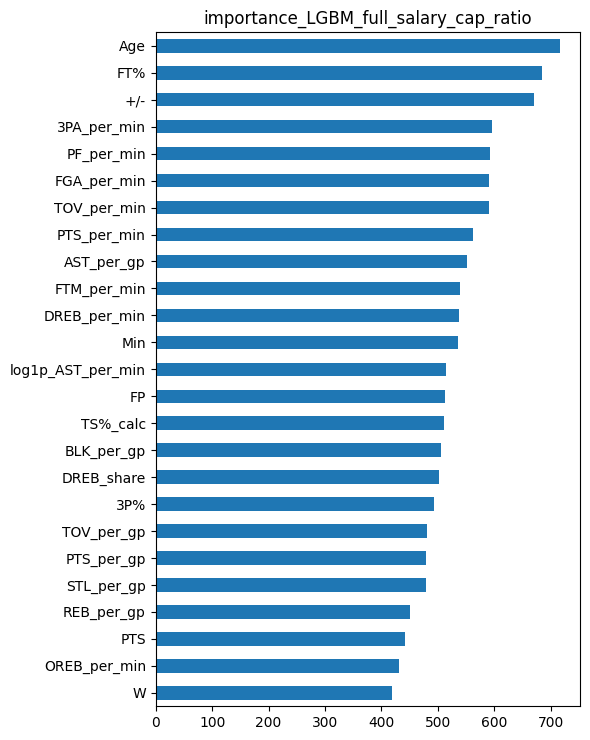

[MLP] full target=salary_cap_ratio  R^2=0.4381 RMSE=0.070034


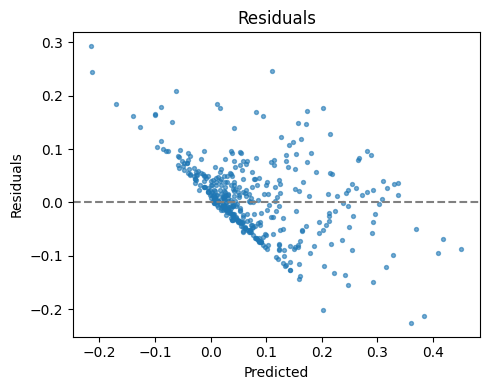

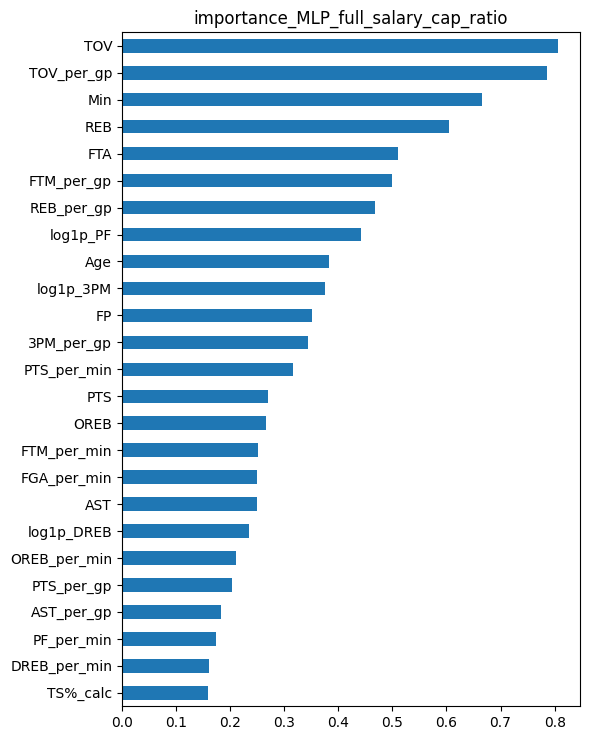

[Ridge] core target=salary_cap_equiv  R^2=0.6918 RMSE=7292010.565103


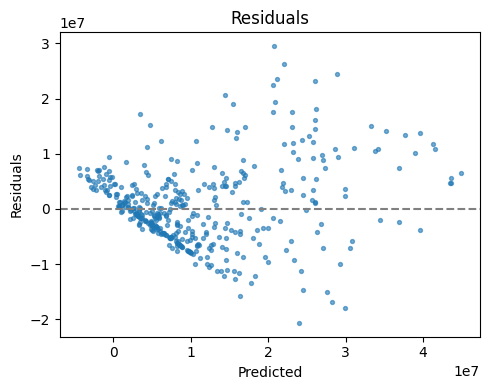

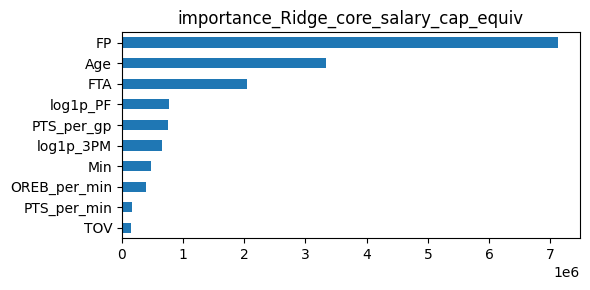

[RF] core target=salary_cap_equiv  R^2=0.7860 RMSE=6075721.620777


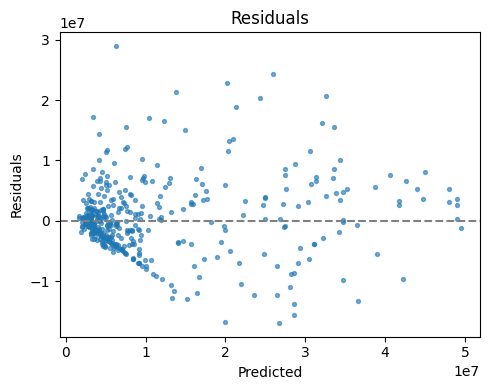

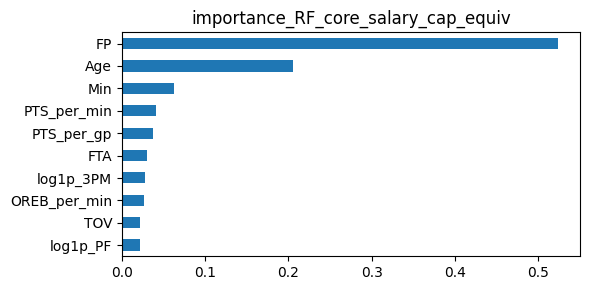

[XGB] core target=salary_cap_equiv  R^2=0.7837 RMSE=6108947.184887


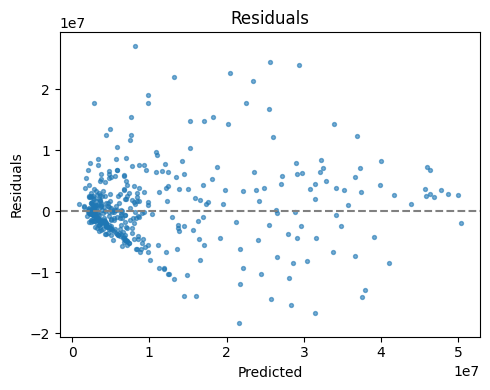

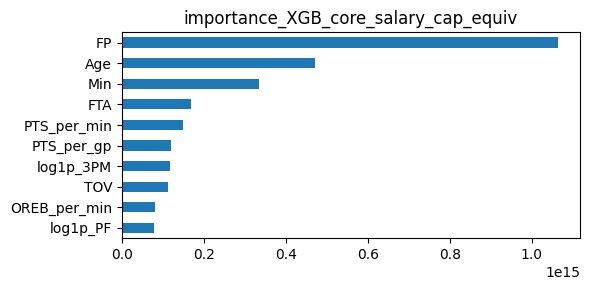

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1494
[LightGBM] [Info] Number of data points in the train set: 1665, number of used features: 10
[LightGBM] [Info] Start training from score 10836565.345179
[LGBM] core target=salary_cap_equiv  R^2=0.7772 RMSE=6200719.606506


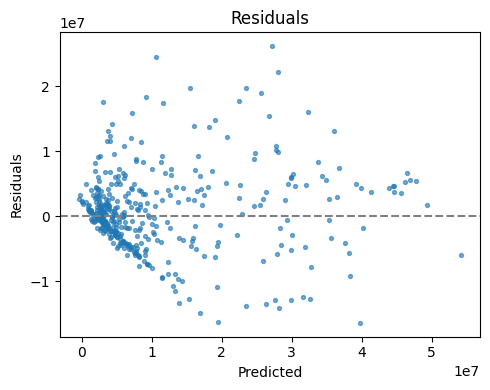

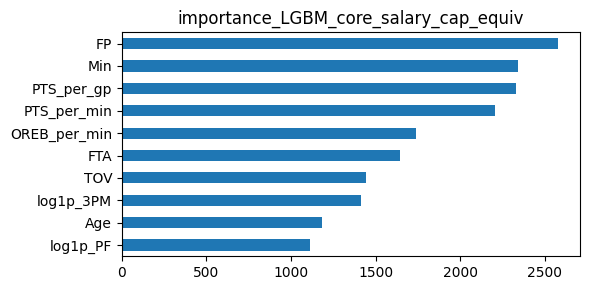

[MLP] core target=salary_cap_equiv  R^2=0.6374 RMSE=7909880.716658


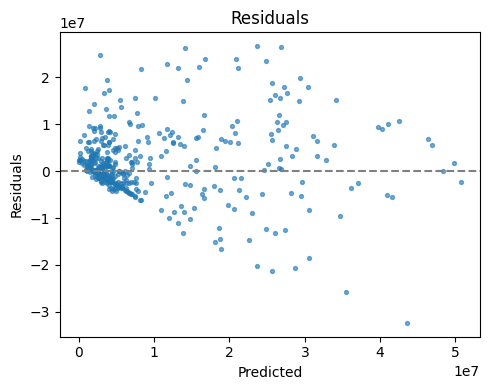

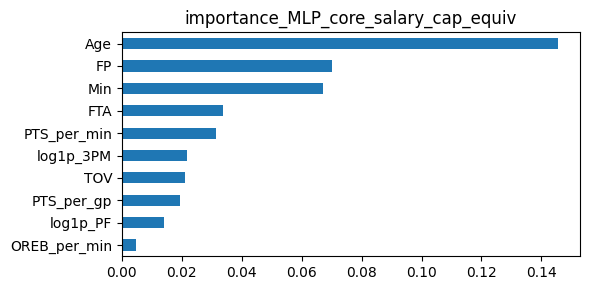

[Ridge] full target=salary_cap_equiv  R^2=0.7183 RMSE=6971104.176563


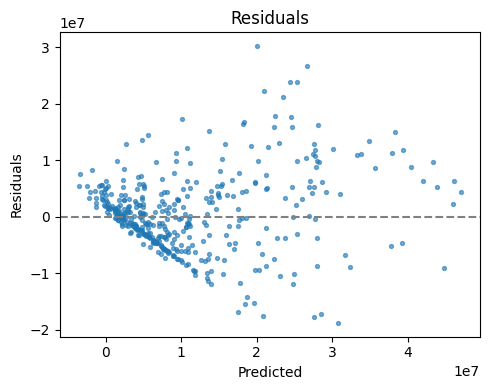

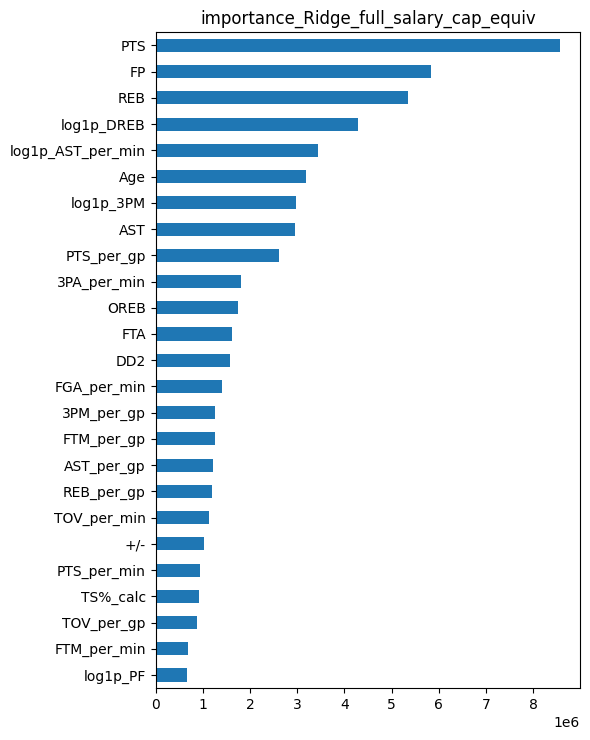

[RF] full target=salary_cap_equiv  R^2=0.7967 RMSE=5922096.802798


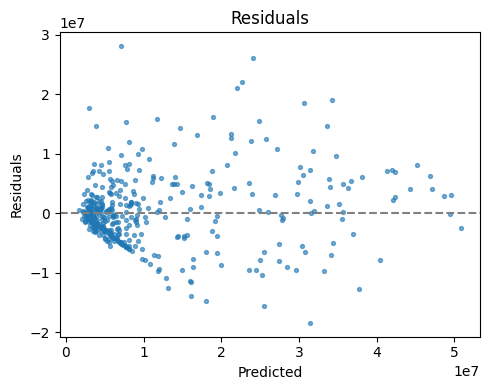

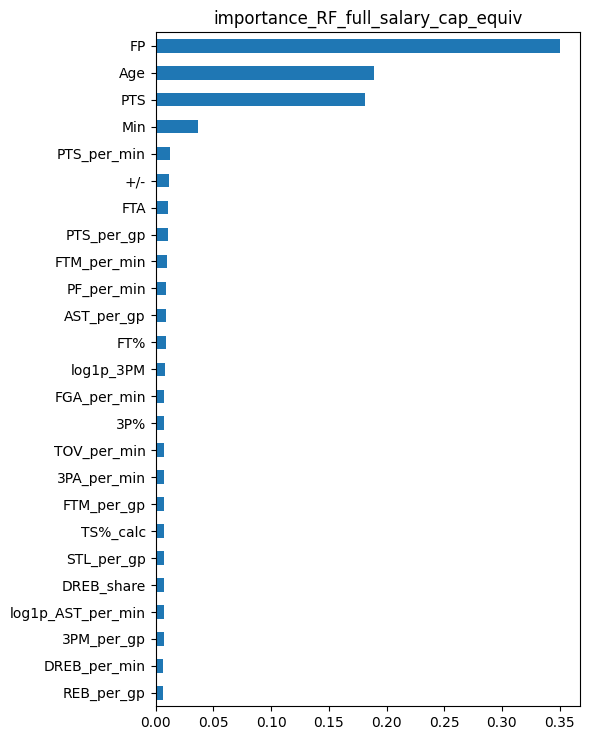

[XGB] full target=salary_cap_equiv  R^2=0.7838 RMSE=6107711.536816


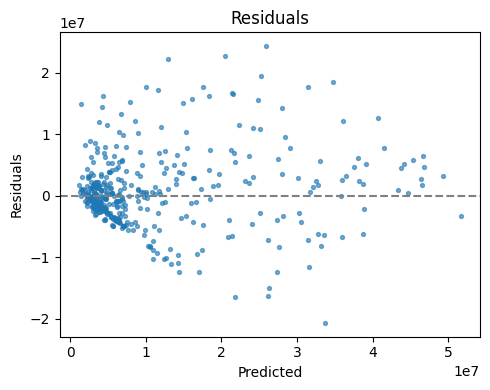

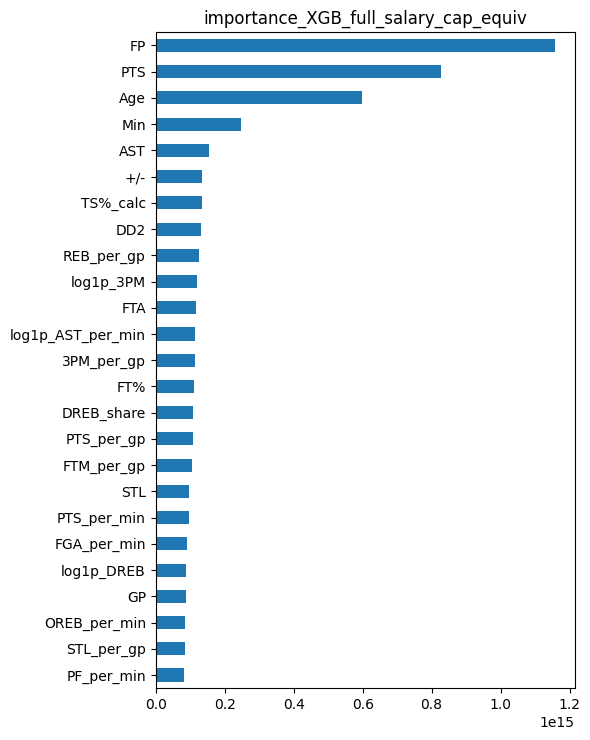

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000730 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7216
[LightGBM] [Info] Number of data points in the train set: 1665, number of used features: 40
[LightGBM] [Info] Start training from score 10836565.345179
[LGBM] full target=salary_cap_equiv  R^2=0.7977 RMSE=5908492.847629


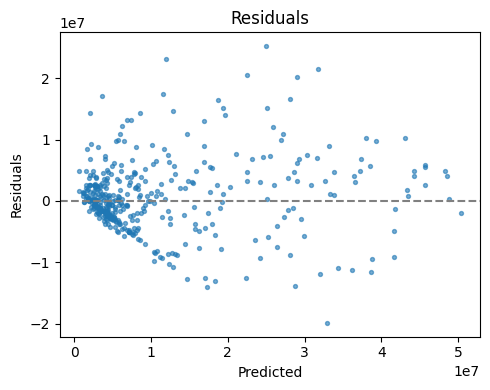

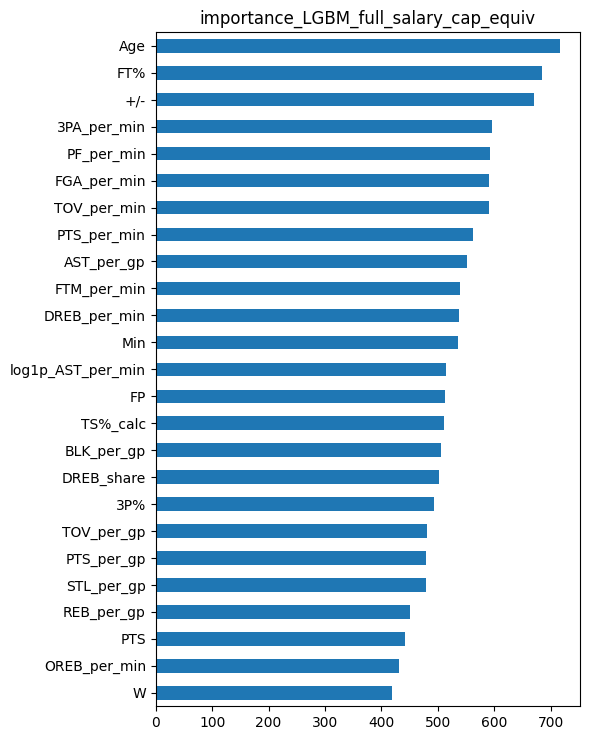

[MLP] full target=salary_cap_equiv  R^2=0.6296 RMSE=7993850.748479


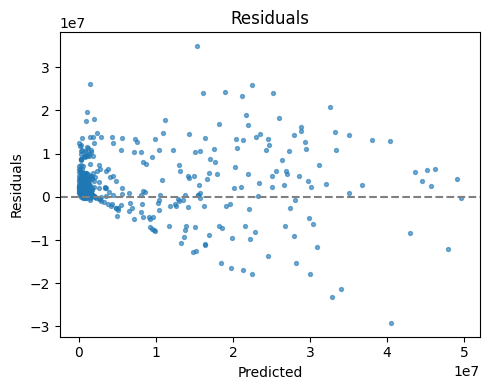

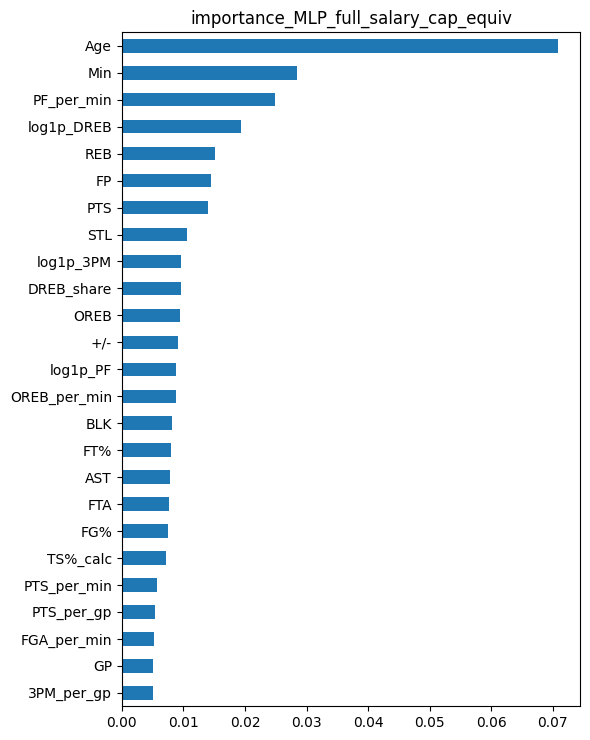

[Ridge] core target=log_salary_cap_ratio  R^2=0.6940 RMSE=0.045020


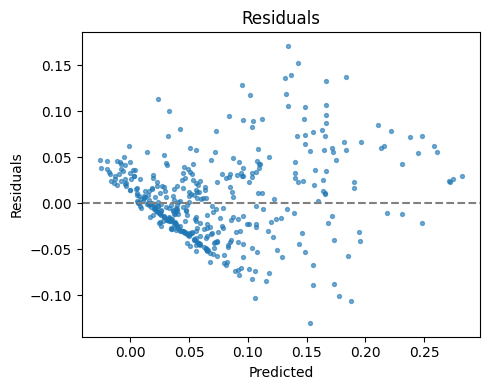

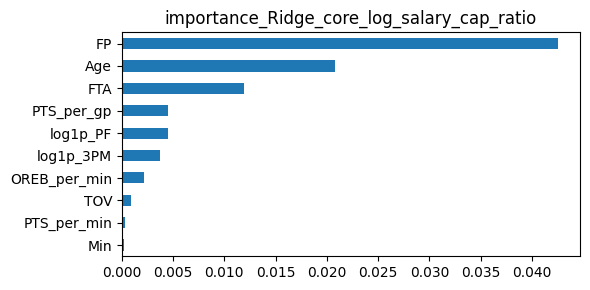

[RF] core target=log_salary_cap_ratio  R^2=0.7827 RMSE=0.037943


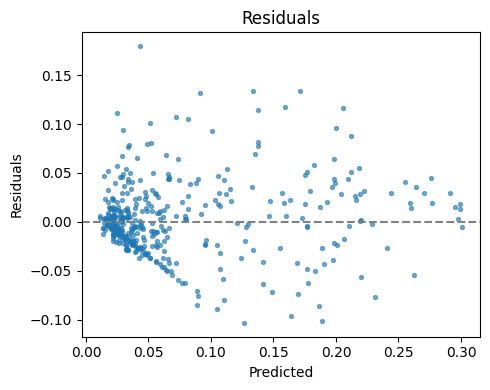

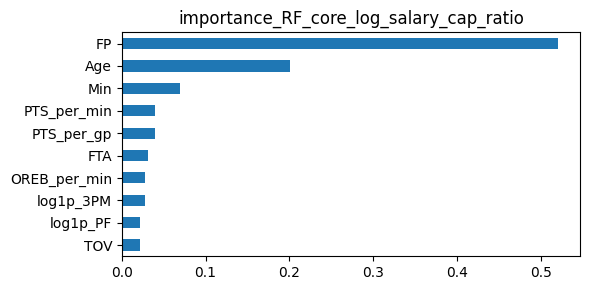

[XGB] core target=log_salary_cap_ratio  R^2=0.7788 RMSE=0.038276


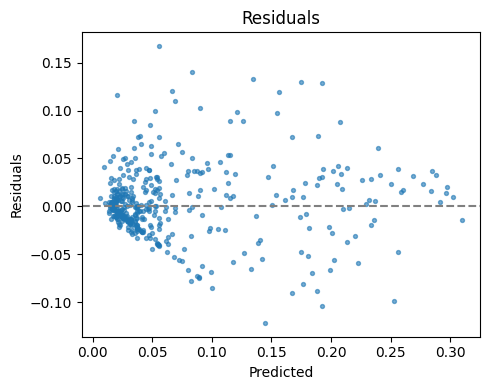

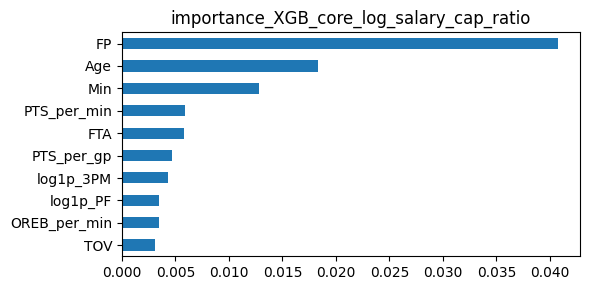

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000194 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1494
[LightGBM] [Info] Number of data points in the train set: 1665, number of used features: 10
[LightGBM] [Info] Start training from score 0.071302
[LGBM] core target=log_salary_cap_ratio  R^2=0.7696 RMSE=0.039070


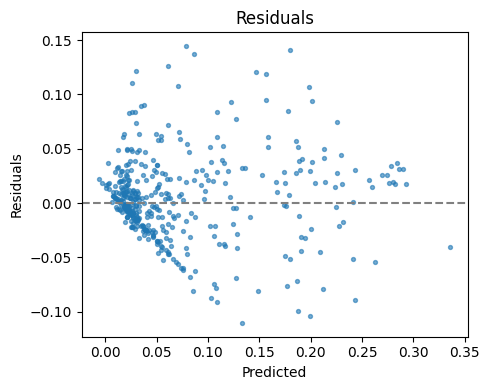

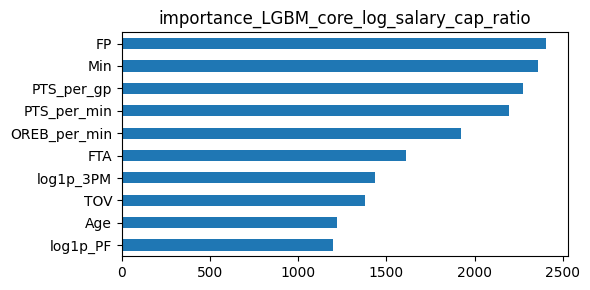

[MLP] core target=log_salary_cap_ratio  R^2=0.6638 RMSE=0.047195


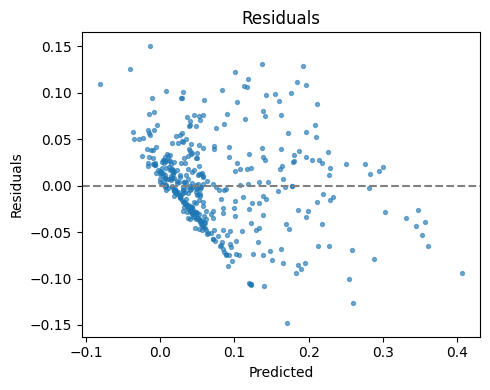

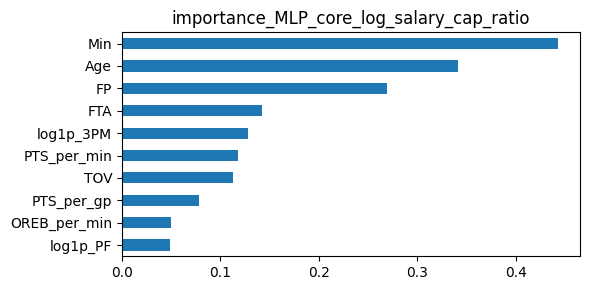

[Ridge] full target=log_salary_cap_ratio  R^2=0.7196 RMSE=0.043100


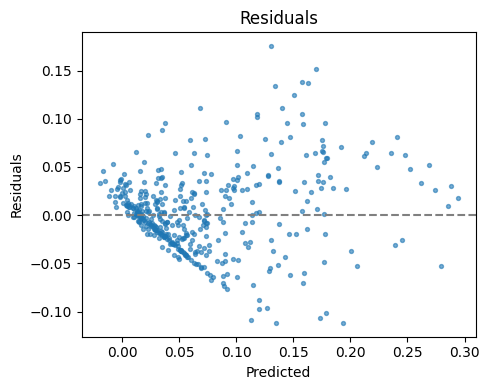

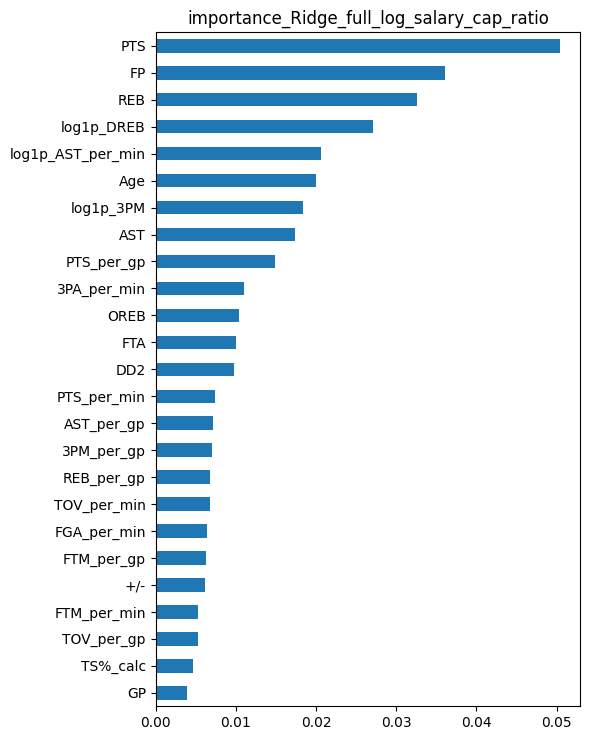

[RF] full target=log_salary_cap_ratio  R^2=0.7912 RMSE=0.037191


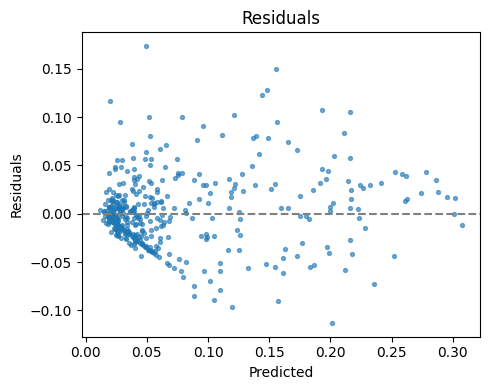

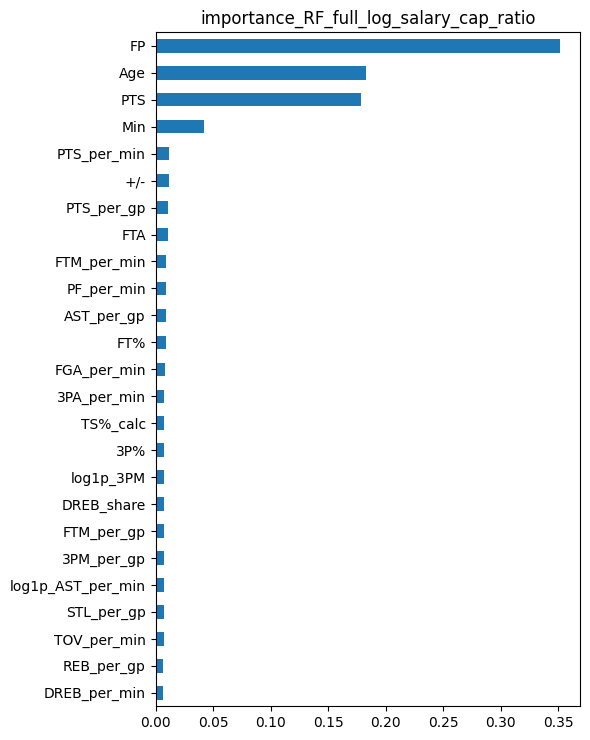

[XGB] full target=log_salary_cap_ratio  R^2=0.7763 RMSE=0.038499


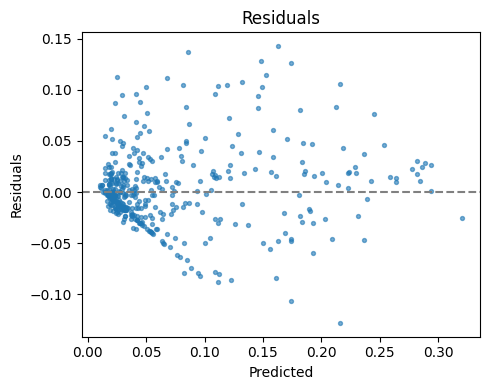

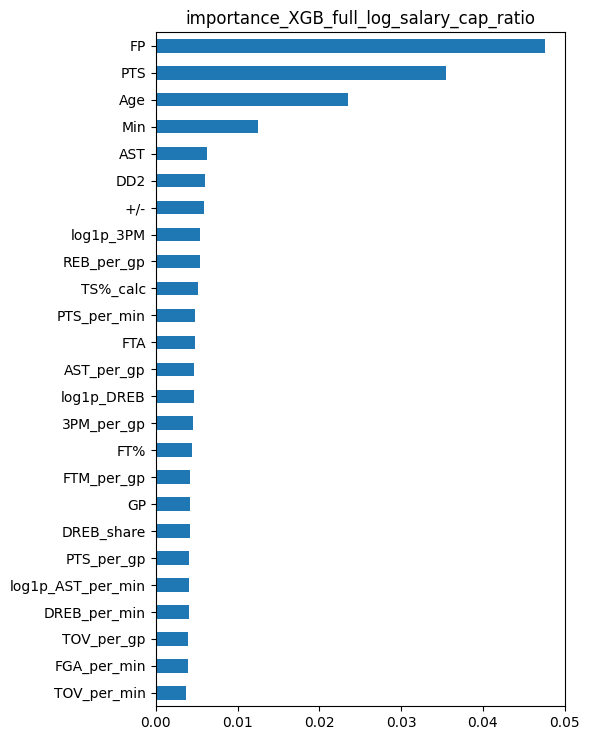

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000489 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7216
[LightGBM] [Info] Number of data points in the train set: 1665, number of used features: 40
[LightGBM] [Info] Start training from score 0.071302
[LGBM] full target=log_salary_cap_ratio  R^2=0.7898 RMSE=0.037315


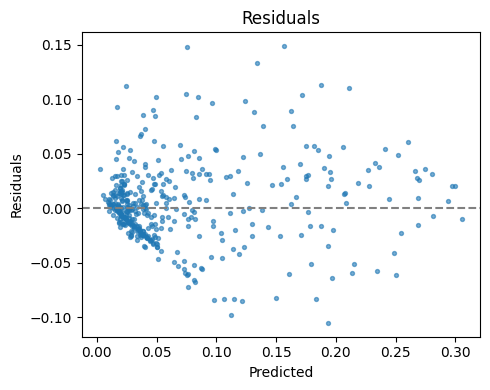

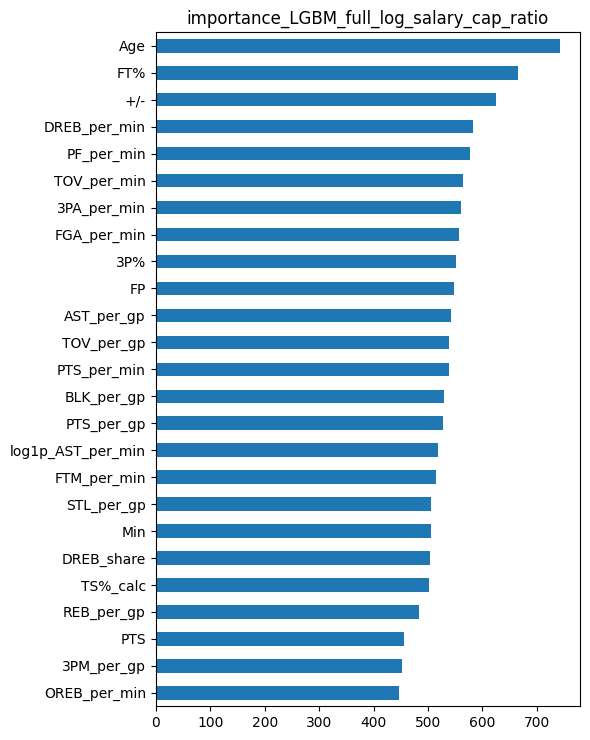

[MLP] full target=log_salary_cap_ratio  R^2=0.3288 RMSE=0.066682


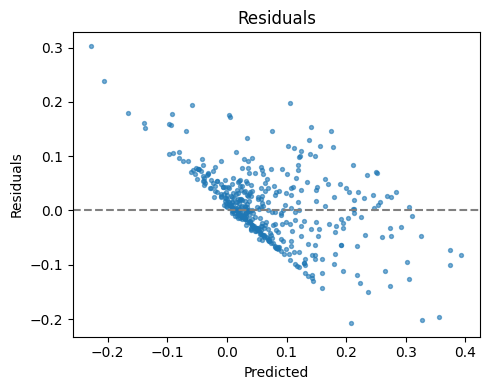

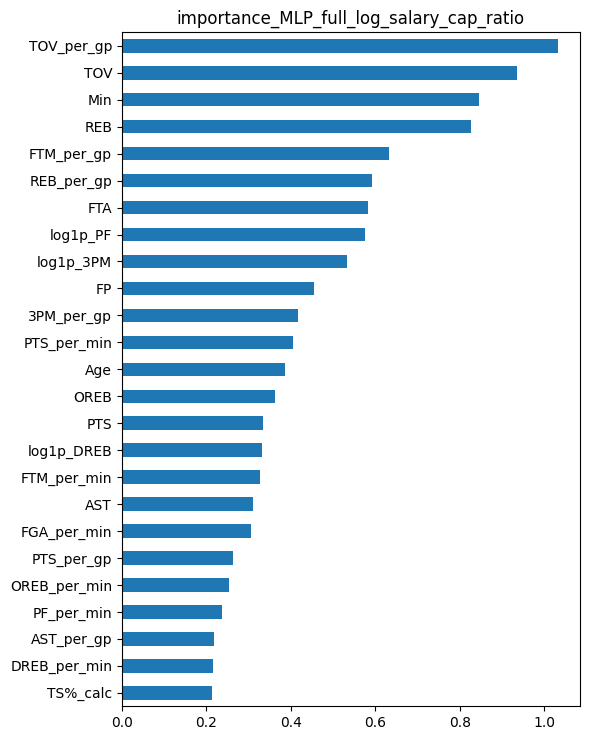

[Ridge] core target=salary_usd  R^2=0.6795 RMSE=6520446.168738


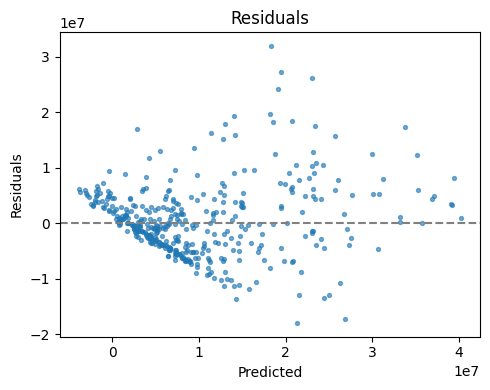

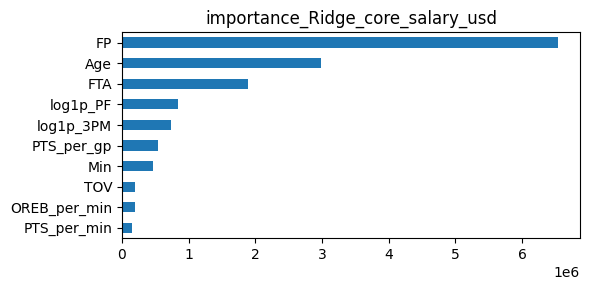

[RF] core target=salary_usd  R^2=0.7581 RMSE=5664753.994887


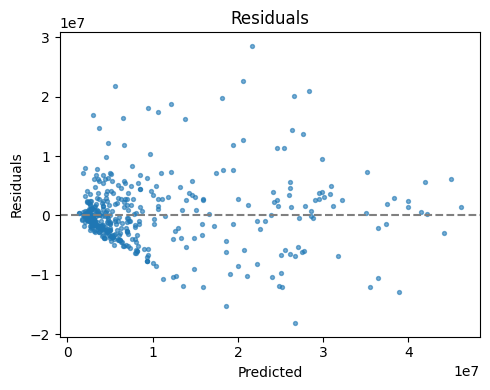

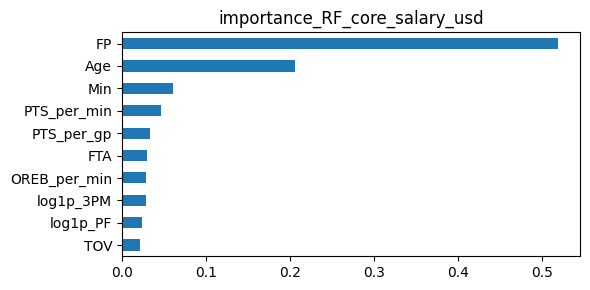

[XGB] core target=salary_usd  R^2=0.7589 RMSE=5655072.915495


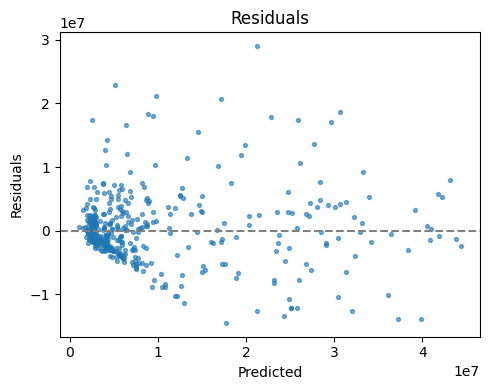

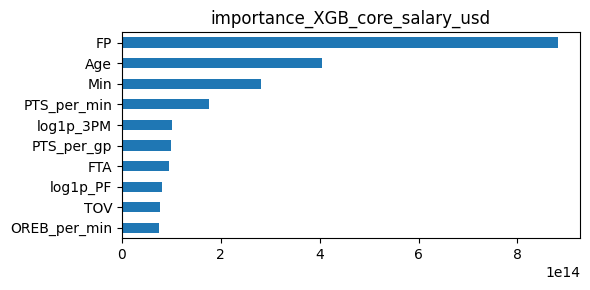

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000172 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1494
[LightGBM] [Info] Number of data points in the train set: 1665, number of used features: 10
[LightGBM] [Info] Start training from score 9651450.866066
[LGBM] core target=salary_usd  R^2=0.7579 RMSE=5666761.666546


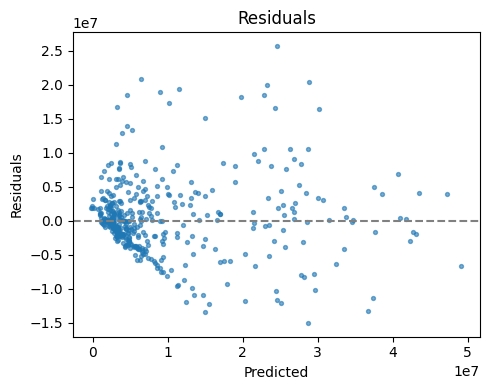

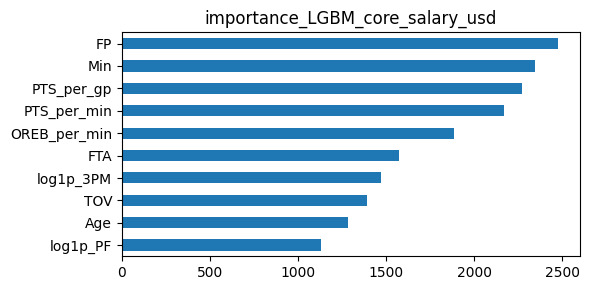

[MLP] core target=salary_usd  R^2=0.6328 RMSE=6978838.228870


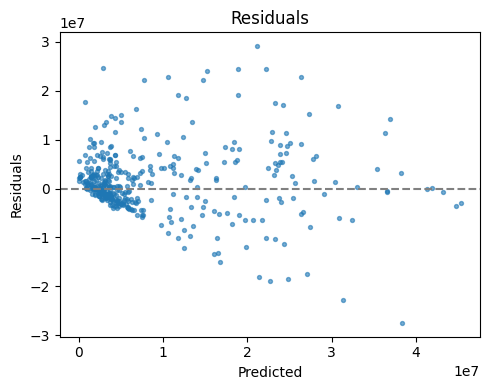

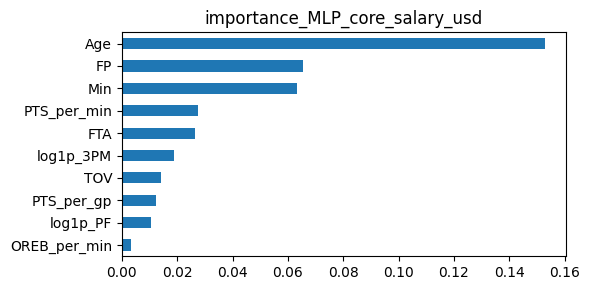

[Ridge] full target=salary_usd  R^2=0.7030 RMSE=6276165.378216


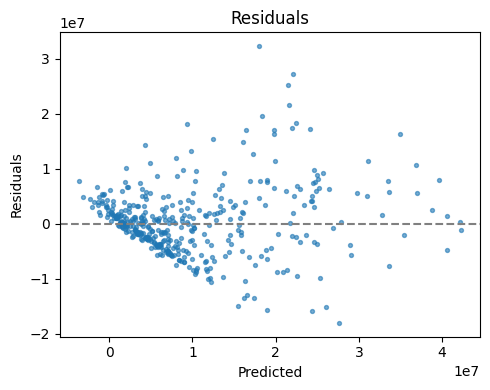

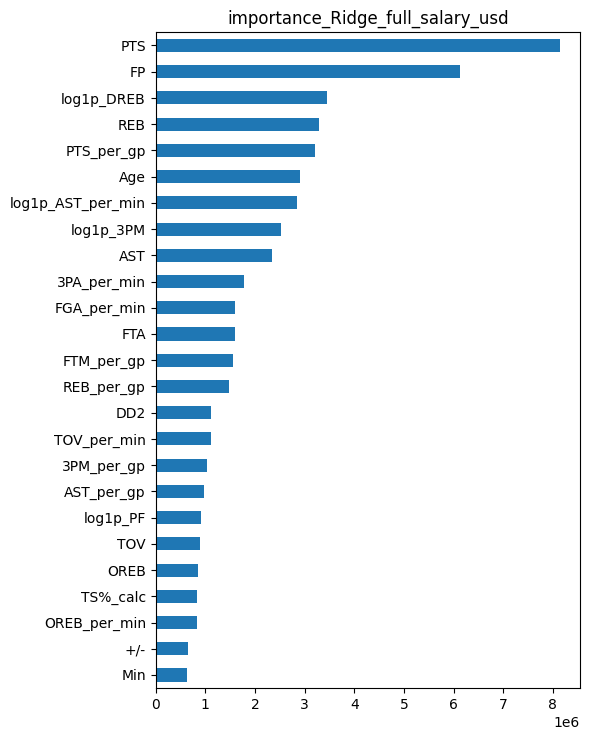

[RF] full target=salary_usd  R^2=0.7691 RMSE=5533473.521795


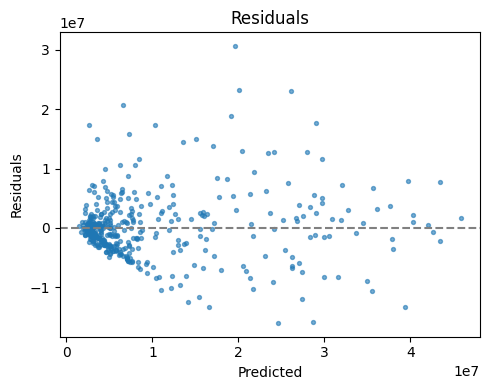

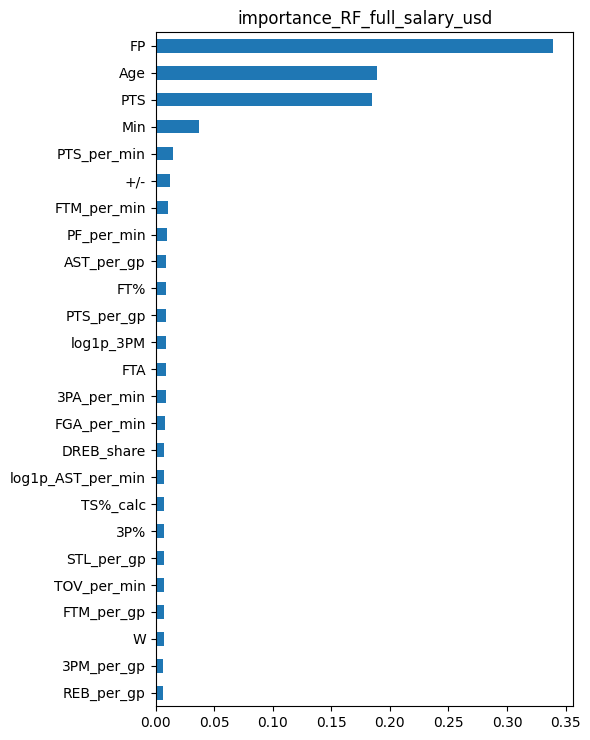

[XGB] full target=salary_usd  R^2=0.7560 RMSE=5688392.206670


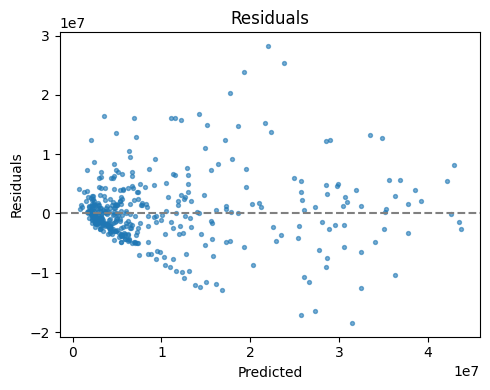

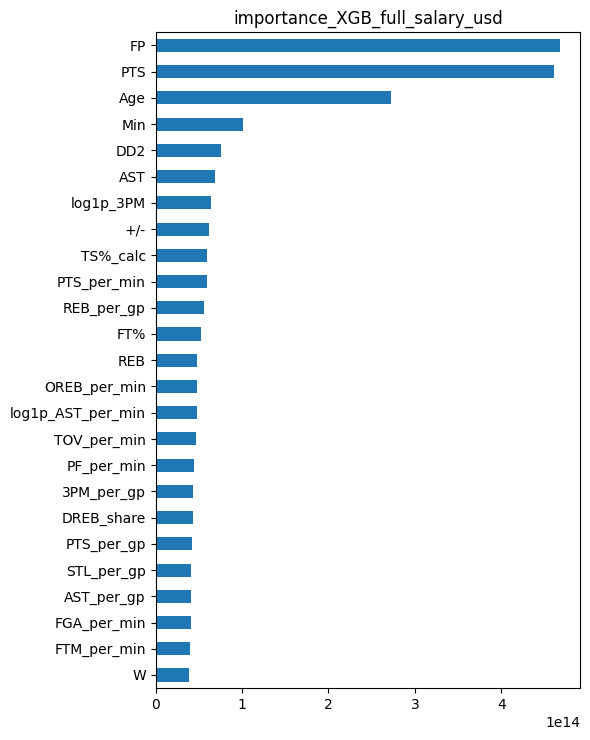

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000470 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7216
[LightGBM] [Info] Number of data points in the train set: 1665, number of used features: 40
[LightGBM] [Info] Start training from score 9651450.866066
[LGBM] full target=salary_usd  R^2=0.7710 RMSE=5511547.781409


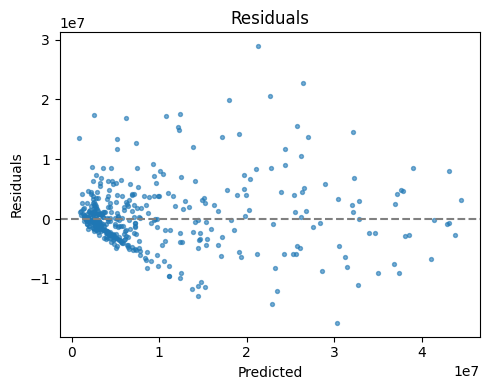

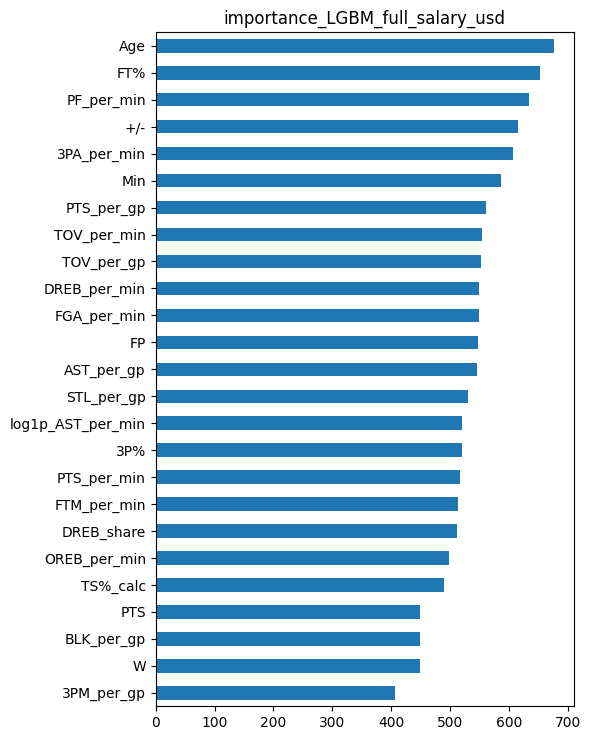

[MLP] full target=salary_usd  R^2=0.6261 RMSE=7042383.660544


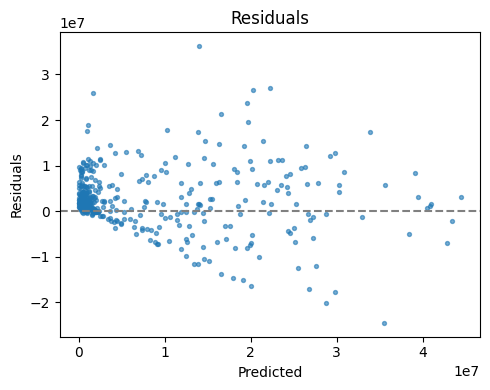

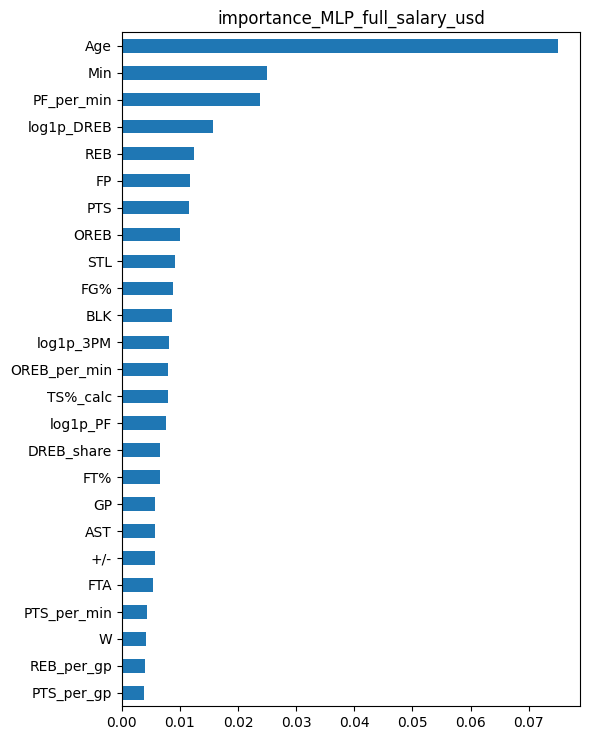

[Ridge] core target=log_salary  R^2=0.5740 RMSE=0.745812


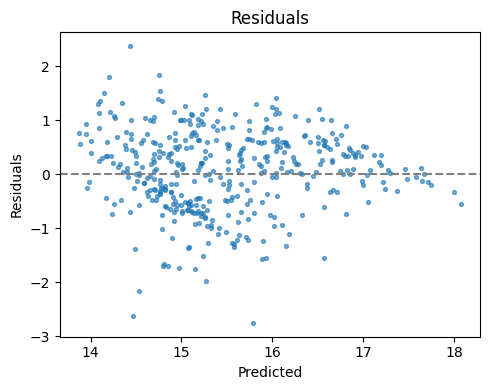

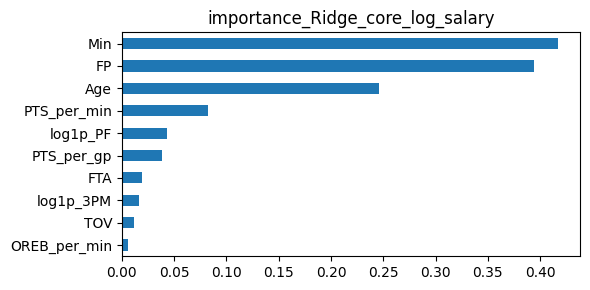

[RF] core target=log_salary  R^2=0.5816 RMSE=0.739072


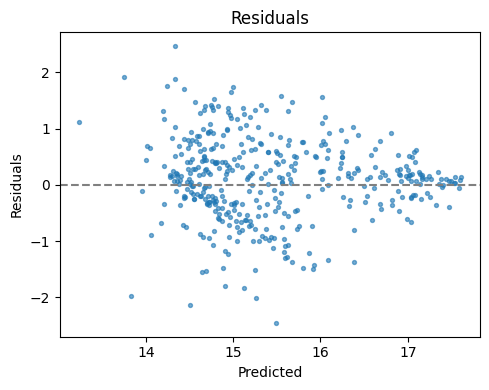

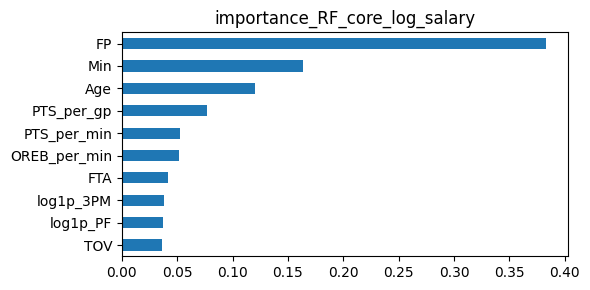

[XGB] core target=log_salary  R^2=0.5908 RMSE=0.730964


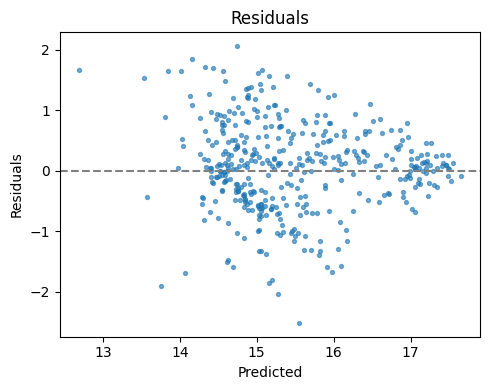

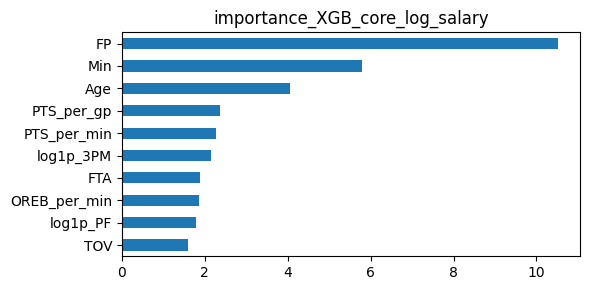

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000182 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1494
[LightGBM] [Info] Number of data points in the train set: 1665, number of used features: 10
[LightGBM] [Info] Start training from score 15.446197
[LGBM] core target=log_salary  R^2=0.4918 RMSE=0.814608


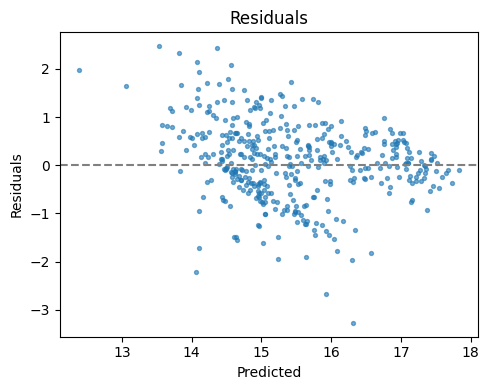

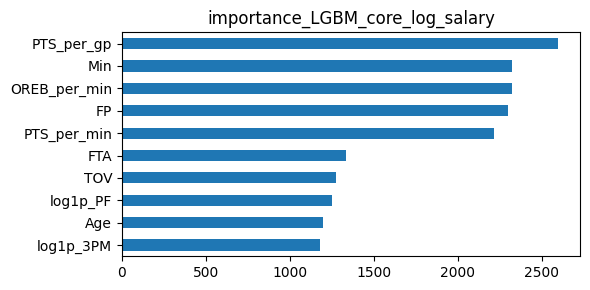

[MLP] core target=log_salary  R^2=0.5793 RMSE=0.741139


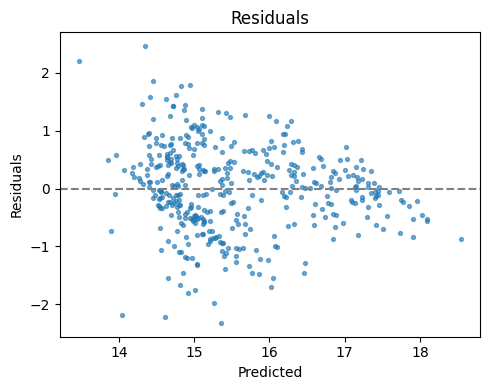

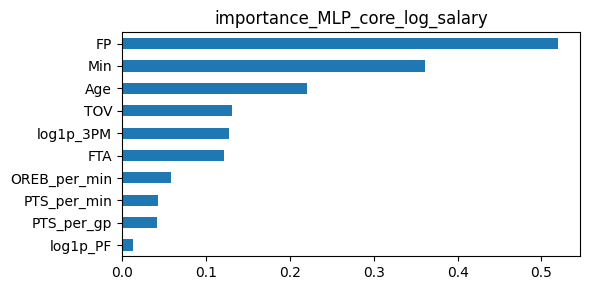

[Ridge] full target=log_salary  R^2=0.5826 RMSE=0.738200


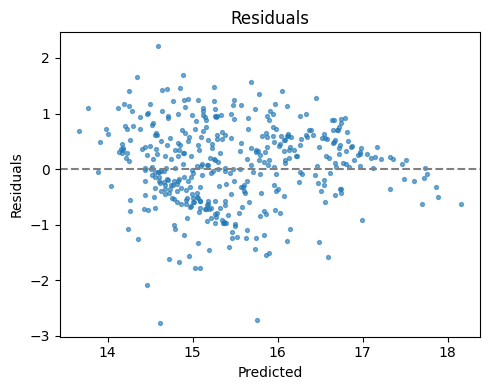

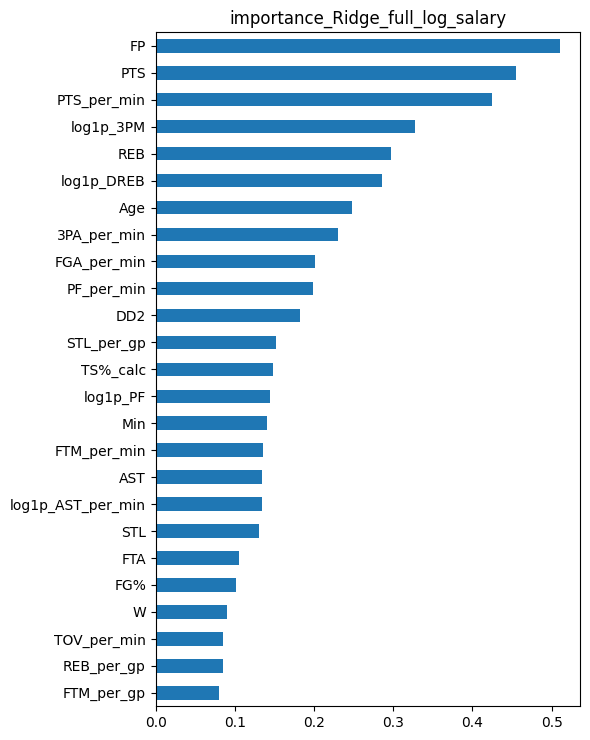

[RF] full target=log_salary  R^2=0.6040 RMSE=0.719070


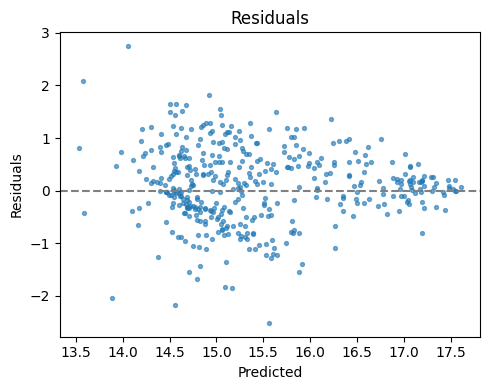

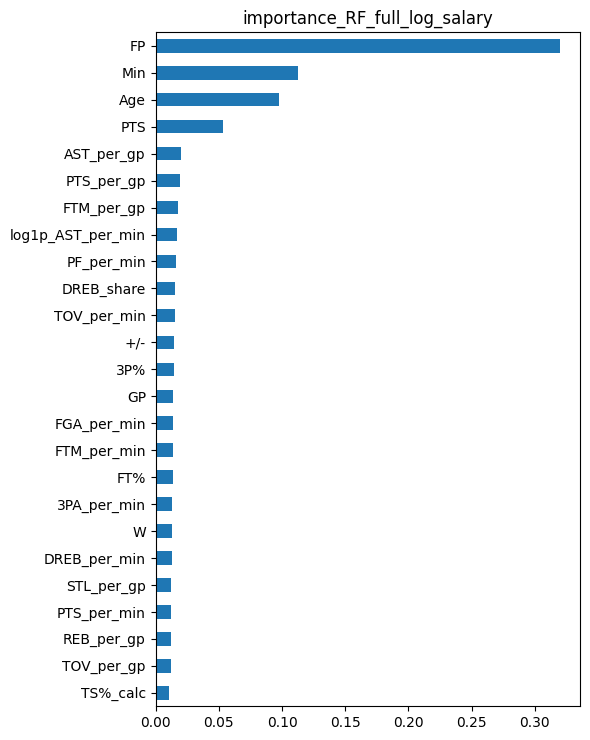

[XGB] full target=log_salary  R^2=0.5736 RMSE=0.746163


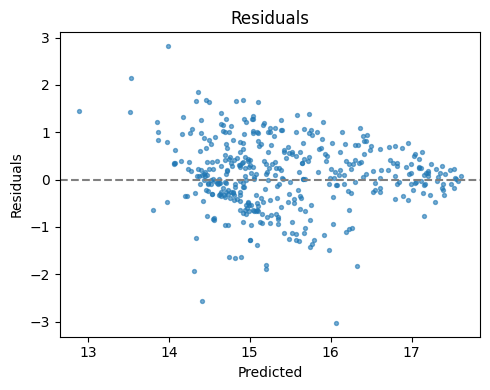

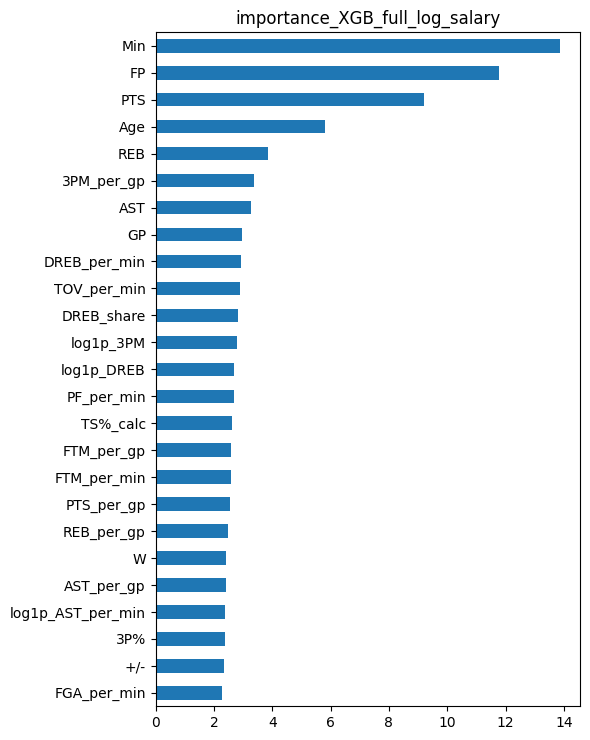

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000675 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7216
[LightGBM] [Info] Number of data points in the train set: 1665, number of used features: 40
[LightGBM] [Info] Start training from score 15.446197
[LGBM] full target=log_salary  R^2=0.5800 RMSE=0.740538


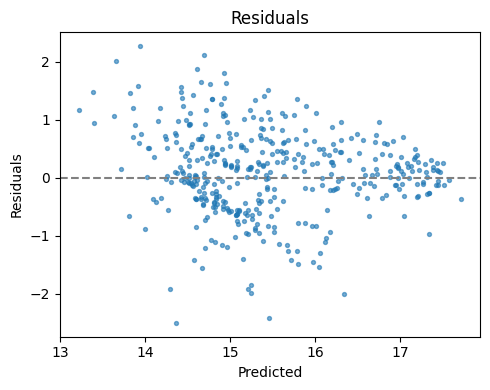

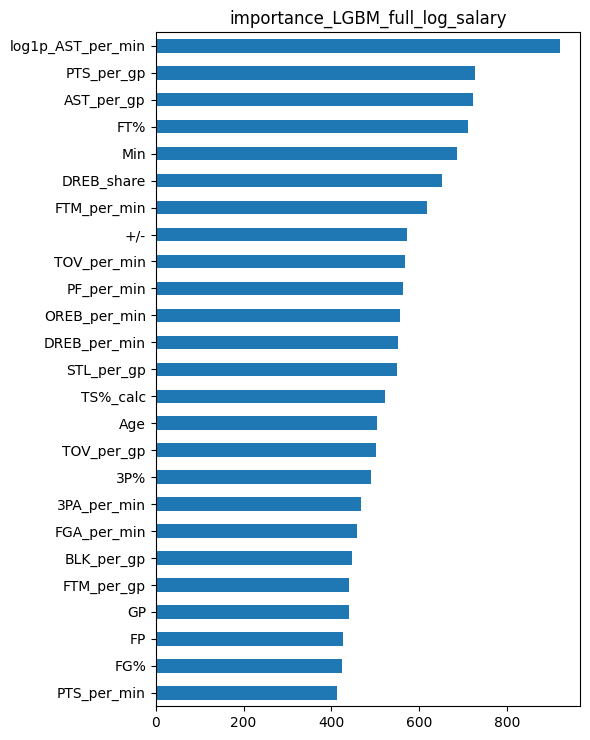

[MLP] full target=log_salary  R^2=0.2010 RMSE=1.021386


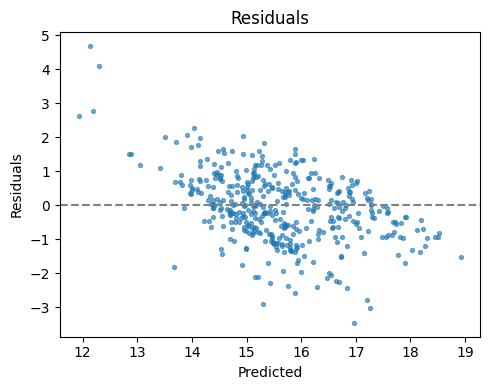

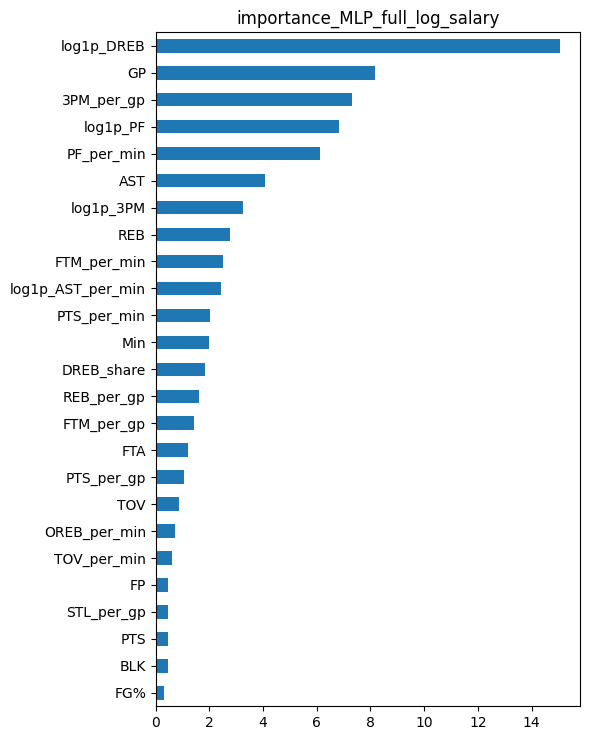

,feature_set,model,target,R2,RMSE
45,full,RF,log_salary,0.603977,7.190696e-01
40,core,XGB,log_salary,0.590767,7.309645e-01
46,full,Ridge,log_salary,0.582625,7.382002e-01
41,core,RF,log_salary,0.581639,7.390718e-01
47,full,LGBM,log_salary,0.579976,7.405385e-01
42,core,MLP,log_salary,0.579295,7.411386e-01
43,core,Ridge,log_salary,0.573973,7.458124e-01
48,full,XGB,log_salary,0.573572,7.461630e-01
44,core,LGBM,log_salary,0.491751,8.146084e-01
49,full,MLP,log_salary,0.200978,1.021386e+00


Saved: reports\baseline\baseline_metrics.csv


In [12]:
# %%
def run_one_block(feature_set_name: str, features: list[str], target: str):
    X, y = make_xy(df, features, target)
    Xtr, Xva, ytr, yva = split_xy(X, y)

    metrics = []
    results = []  # (name, pred, imp)

    # 线性
    for fit_func in [fit_ridge]:
        name, model, pred, imp = fit_func(Xtr, ytr, Xva, yva)
        r2, rmse = evaluate(yva, pred)
        print(f"[{name}] {feature_set_name} target={target}  R^2={r2:.4f} RMSE={rmse:.6f}")
        plot_residuals(yva, pred, OUT_DIR / f"resid_{name}_{feature_set_name}_{target}.png")
        save_importance(imp, OUT_DIR / f"importance_{name}_{feature_set_name}_{target}.csv")
        metrics.append({"feature_set": feature_set_name, "model": name, "target": target, "R2": r2, "RMSE": rmse})
        results.append((name, pred, imp))

    # 非线性
    for fit_func in [fit_rf, fit_xgb, fit_lgbm, fit_mlp]:
        name, model, pred, imp = fit_func(Xtr, ytr, Xva, yva)
        if name is None:   # 该模型不可用（如没装 xgboost/lgbm）
            continue
        r2, rmse = evaluate(yva, pred)
        print(f"[{name}] {feature_set_name} target={target}  R^2={r2:.4f} RMSE={rmse:.6f}")
        plot_residuals(yva, pred, OUT_DIR / f"resid_{name}_{feature_set_name}_{target}.png")
        save_importance(imp, OUT_DIR / f"importance_{name}_{feature_set_name}_{target}.csv")
        metrics.append({"feature_set": feature_set_name, "model": name, "target": target, "R2": r2, "RMSE": rmse})
        results.append((name, pred, imp))

    return pd.DataFrame(metrics).sort_values(["target","R2"], ascending=[True, False])

# === 跑起来 ===
all_metrics = []
for tgt in TARGETS_TO_RUN:
    all_metrics.append(run_one_block("core", core_feats, tgt))
    all_metrics.append(run_one_block("full", full_feats, tgt))

all_metrics = pd.concat(all_metrics, ignore_index=True)
display(all_metrics.sort_values(["target","R2"], ascending=[True, False]))

# 保存总表
out_csv = OUT_DIR / "baseline_metrics.csv"
all_metrics.to_csv(out_csv, index=False)
print("Saved:", out_csv)

# %% [markdown]
# ## How to read the results
# - Check `reports/baseline/baseline_metrics.csv` to compare:
#   - models: Ridge vs RF vs XGB vs LGBM vs MLP
#   - feature sets: core vs full
#   - targets: salary_cap_ratio (recommended) vs others
# - Prefer: full+XGB/LGBM for best accuracy; core+Ridge for interpretation.
# - If MLP underperforms, it's often due to small data size and limited tuning—boosting trees are usually stronger here.